In [2]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

ModuleNotFoundError: No module named 'jwst_backgrounds'

In [2]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

# create no noise or background image

In [8]:
band = 'f106'
num_samples = 100000
grid_supersample = 3

lens = SampleSkyPyLens()

# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'cdm_subhalos_tuple')))

model = lens.get_array(num_pix=51 * grid_supersample, side=5.61)

In [9]:
calc = build_default_calc('roman', 'wfi', 'imaging')

# set scene size settings
calc['configuration']['max_scene_size'] = 5

# set instrument
calc['configuration']['instrument']['filter'] = band

# set detector
calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

# turn off noise sources
calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

# set background
calc['background'] = 'none'

# convert array from counts/sec to astronomical magnitude
mag_array = pandeia_input._get_mag_array(lens, model, num_samples, band, suppress_output=False)

# add point sources to Pandeia input
norm_wave = pandeia_input._get_norm_wave(band)
calc, num_point_sources = pandeia_input._phonion_sample(calc, mag_array, lens, num_samples, norm_wave)

100%|██████████| 11249/11249 [01:26<00:00, 130.39it/s]

Point source conversion complete: placed 11249 point sources


In [13]:
# get Pandeia image
pandeia, _ = pandeia_input.get_pandeia_image(calc)

np.save(os.path.join(array_dir, f'no_noise_or_background_{grid_supersample}_{num_samples}.npy'), pandeia)

Performing Pandeia calculation...


Pandeia calculation complete in 0:14:17


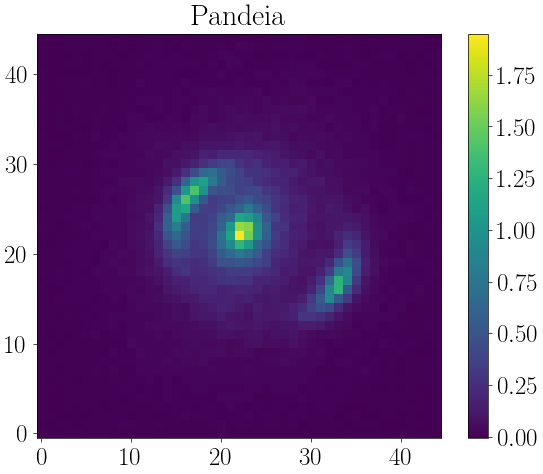

In [4]:
plot.plot(title='Pandeia',
          array=pandeia,
          colorbar=True)

# Use WebbPSF

In [4]:
import astropy.io.fits as pyfits

# load PSF from WebbPSF
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)
plt.matshow(np.log10(kernel))
plt.show()

NameError: name 'os' is not defined

In [ ]:
# set up lenstronomy kwargs_psf input
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

# Generate images with various PSFs

In [5]:
lens = SampleSkyPyLens()

num_pix = 45
side = 4.95
band = 'f106'

## Grab default substructure

In [6]:
# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'cdm_subhalos_tuple')))

## No PSF

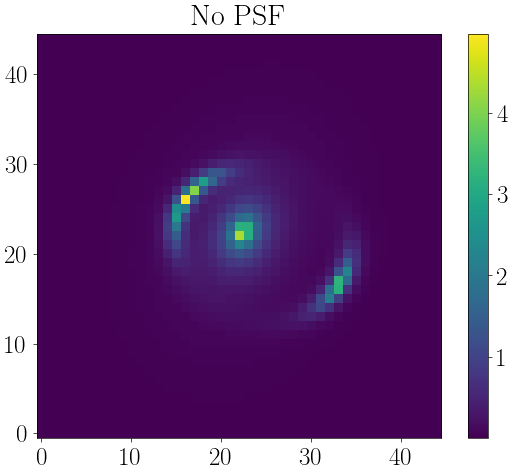

(45, 45)


In [7]:
kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none, side=side)

plot.plot(title='No PSF',
          array=no_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'no_psf.npy'), no_psf)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [8]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

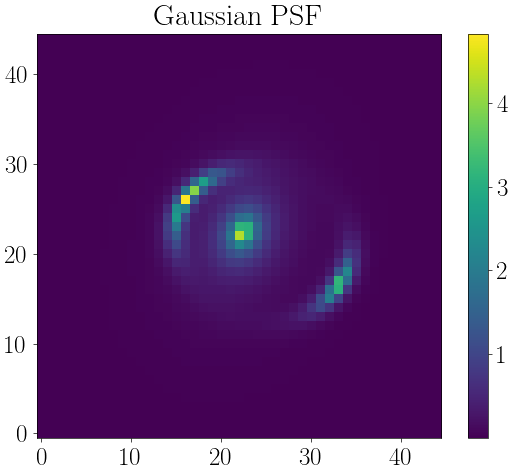

(45, 45)


In [9]:
kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian, side=side)

plot.plot(title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'gaussian_psf.npy'), gaussian_psf)

print(gaussian_psf.shape)

In [ ]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'no_noise_or_background_3_100000.npy'))

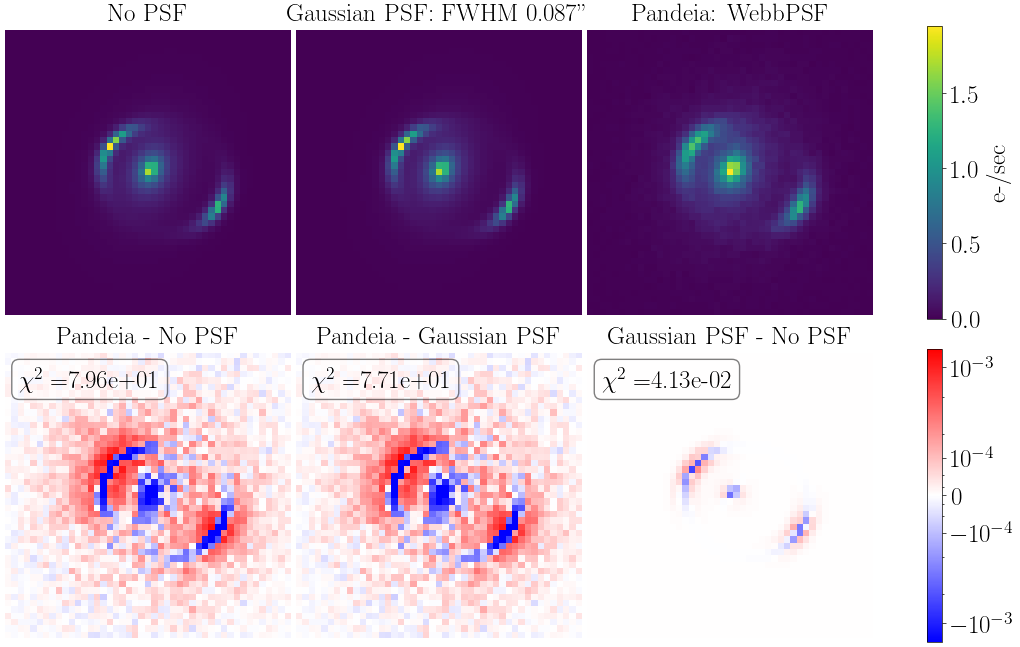

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.02})

fontsize = 18

matplotlib.rcParams.update({'font.size': fontsize})

array_list = [no_psf, gaussian_psf, pandeia]
title_list = ['No PSF', f'Gaussian PSF: FWHM {psf_fwhm.get(band)}"', 'Pandeia: WebbPSF']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i], fontsize=fontsize)
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('e-/sec', rotation=90)

normalized_no_psf = stats.normalize(no_psf)
normalized_gaussian_psf = stats.normalize(gaussian_psf)
normalized_pandeia = stats.normalize(pandeia)

array_list = [normalized_pandeia - normalized_no_psf, normalized_pandeia - normalized_gaussian_psf, normalized_gaussian_psf - normalized_no_psf]
title_list = ['Pandeia - No PSF', 'Pandeia - Gaussian PSF', 'Gaussian PSF - No PSF']

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(no_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, no_psf))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.0001)

for i, array in enumerate(array_list):
    axis_2 = ax[1][i].imshow(array, cmap='bwr', norm=norm)
    ax[1][i].set_title(title_list[i], fontsize=fontsize)
    ax[1][i].set_axis_off()

overplot.text_boxes(ax[1], chi_square_list, fontsize=fontsize)

fig.colorbar(axis_2, ax=ax[1], ticks=[-0.001, -0.0001, 0, 0.0001, 0.001])

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()

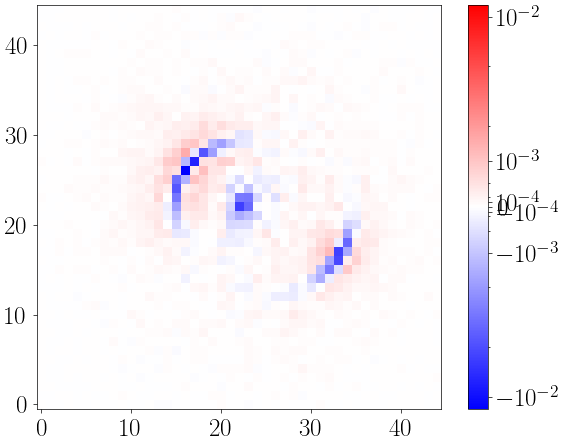

In [11]:
diagnostic_plot.residual(stats.normalize(pandeia), stats.normalize(no_psf))

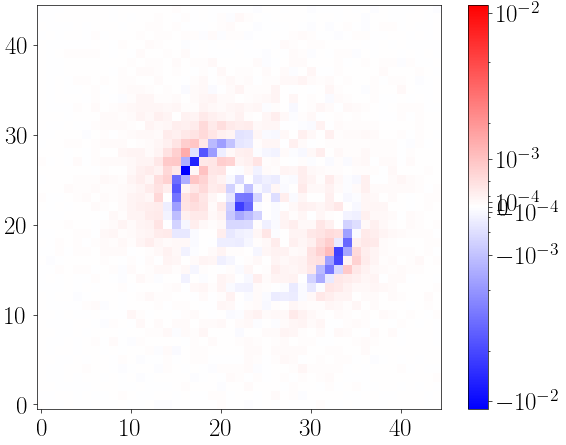

In [12]:
diagnostic_plot.residual(stats.normalize(pandeia), stats.normalize(gaussian_psf))

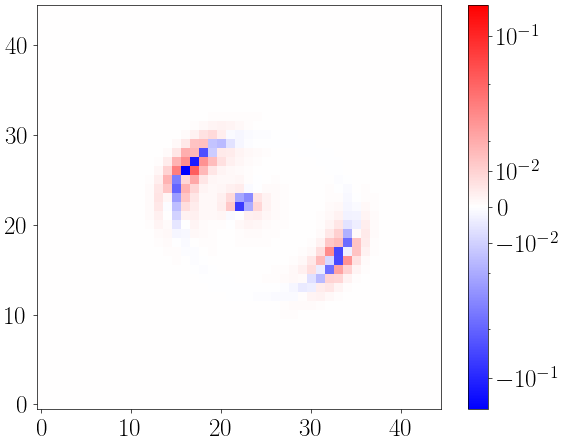

In [13]:
diagnostic_plot.residual(pandeia - no_psf, pandeia - gaussian_psf)